## Forecasting LSTM with SSI at 549.41nm (green), 698.85nm (red), 798.83nm (infrared)

This is a notebook created to train the LSTM to forecast TSI, and to make tests with different settings looking for the best one. It is being costumized with the purpose to generate results to the work will be submitted to JSWSC.

In [1]:
from library import *
from matplotlib import dates

Using TensorFlow backend.
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ami\anaconda3\envs\rworkflow\lib

In [2]:
np.random.seed(7)

In [87]:
oPath = './output_files/SSI Predictions/'
interval='1'
timeTerm=interval+" Day"
# line = '549.41'
# line = '698.85'
line = '798.83'


In [88]:
P1 = np.asarray(np.loadtxt('./partial_output_files/412D/P_'+line+'_412dias'+interval+'days.csv'))
T1 = np.asarray(np.loadtxt('./partial_output_files/412D/T_'+line+'_412dias'+interval+'days.csv'))

P2 = np.asarray(np.loadtxt('./partial_output_files/301D/P_'+line+'_301dias'+interval+'days.csv'))
T2 = np.asarray(np.loadtxt('./partial_output_files/301D/T_'+line+'_301dias'+interval+'days.csv'))

P3 = np.asarray(np.loadtxt('./partial_output_files/129D/P_'+line+'_129dias'+interval+'days.csv'))
T3 = np.asarray(np.loadtxt('./partial_output_files/129D/T_'+line+'_129dias'+interval+'days.csv'))
Time3 = np.asarray(np.loadtxt('./partial_output_files/129D/Time_'+line+'_129dias'+interval+'days.csv'))

P4 = np.asarray(np.loadtxt('./partial_output_files/81D/P_'+line+'_81dias'+interval+'days.csv'))
T4 = np.asarray(np.loadtxt('./partial_output_files/81D/T_'+line+'_81dias'+interval+'days.csv'))
Time4 = np.asarray(np.loadtxt('./partial_output_files/81D/Time_'+line+'_81dias'+interval+'days.csv'))


In [89]:
P1 = np.transpose(P1)
T1 = T1.reshape(-1,1)

P2 = np.transpose(P2)
T2 = T2.reshape(-1,1)

P3 = np.transpose(P3)
T3 = T3.reshape(-1,1)

P4 = np.transpose(P4)
T4 = T4.reshape(-1,1)

PT = P3
TT = T3
testSet="set3"
print(P1.shape)
print(P2.shape)
print(P3.shape)
print(T1.shape)
#print(Time1.shape)

(412, 40)
(301, 40)
(129, 40)
(412, 1)


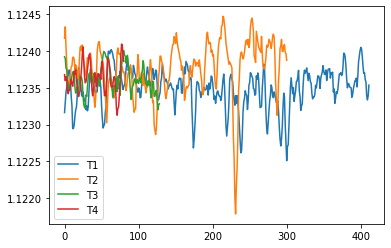

In [90]:
plt.plot(T1, label='T1')
plt.plot(T2, label='T2')
plt.plot(T3, label='T3')
plt.plot(T4, label='T4')
plt.legend()

In [91]:
# print(np.count_nonzero(np.isnan(P1)))
# print(np.count_nonzero(np.isnan(P2)))
# print(np.count_nonzero(np.isnan(P3)))
# print(np.count_nonzero(np.isnan(P4)))

Standarizing the data:

In [92]:
# MinMax [0,1] for both IO:
# scalerIn = MinMaxScaler(feature_range=(0, 1))
# scalerOut = MinMaxScaler(feature_range=(0, 1))
# scaling = "O01"

# MinMax [0,1] for Input and MinMax [-1,1] for Output:
scalerIn = MinMaxScaler(feature_range=(0, 1))
scalerOut = MinMaxScaler(feature_range=(-1, 1))
scaling = "O-11"

# # MinMax [0,1] for Input and Standard for Output:
# scalerIn = MinMaxScaler(feature_range=(0, 1))
# scalerOut = StandardScaler()
# scaling = "OStd"

In [93]:
scalerIn.fit(np.concatenate((P1,P2,P4)))
scalerOut.fit(np.concatenate((T1,T2,T4)))

x1 = scalerIn.transform(P1)
x2 = scalerIn.transform(P2)
x3 = scalerIn.transform(P3)
x4 = scalerIn.transform(P4)
xt = scalerIn.transform(PT)

y1 = scalerOut.transform(T1)
y2 = scalerOut.transform(T2)
y3 = scalerOut.transform(T3)
y4 = scalerOut.transform(T4)
yt = scalerOut.transform(TT)

Defining a mask value (an outlier value) to replace the *nan* values of the output vector. (The nets can't deal with *nan* values)

In [97]:
units = 30
epochs = 50
shuffle = True
test_size = 0.2
#loss='mse'
loss = 'mean_squared_error'
optimizer = 'adam'
#optimizer = 'rmsprop'
afunction = 'tanh'
dropout = 0.3
lookback = 1
batchRate = 0.05

In [100]:
# outputPath = './output_files/Activation/121.5_'
net = "lstm"
mse = []
testsqtd = 1
error =[]
lstm = []

# expName = outputPath + "_simple_HU2"
# expName = outputPath + "_lstmHU1"
# expName = outputPath + "_gruHU2"

# expName = outputPath + "lstm_"+afunction
# expName = outputPath + "gru_"+afunction

# expName = outputPath + net+"_" + scaling
# expName = outputPath + "gru_" + scaling
expName = "teste"

#unitsNumbers = range(15, 16)
# unitsNumbers = range(1, 11, 1)
# unitsNumbers = range(10,51,5)
#epochsNumbers = [50, 60, 80, 100, 150, 300]
# batchSizes = [32,64,128,256,512]
# lookbacks = range(1,2)
#dropouts = [0.,0.1,0.2,0.40,0.6]
batchRates = [0.01]
# batchSizes = [16]

# for batch_size in batchSizes:
# for units in unitsNumbers:
    
p = (np.concatenate((x1,x2,x4)))
t = (np.concatenate((y1,y2,y4)))

sxTest = xt
syTest = yt

sxTrain, sxVal, syTrain, syVal= train_test_split(p, t, test_size=test_size, shuffle=shuffle)

sxTrain = sxTrain.reshape((sxTrain.shape[0], lookback, sxTrain.shape[1])) 
sxVal = sxVal.reshape((sxVal.shape[0],  lookback, sxVal.shape[1]))
sxTest = sxTest.reshape((sxTest.shape[0],  lookback, sxTest.shape[1])) 


for batchRate in batchRates:
    batch_size = int(sxTrain.shape[0] * batchRate)
#for dropout in dropouts:
#for units in unitsNumbers: # used for units number tests
#for lookback in lookbacks: #used only for lookback tests
    
    for j in range(testsqtd):
        
        #keras.backend.clear_session()
        
#         print('\n\nTest #'+str(j+1)+' for '+str(units)+' units:') # used for batch_size tests
        #print('\n\nTest #'+str(j+1)+' for lookback = '+str(lookback)+':') # used for lookback tests
        #print('\n\nTest #'+str(j+1)+' for '+str(units)+' units:') # used for units number tests
        #print('\n\nTest #'+str(j+1)+' for dropout rate = '+str(dropout)+":") # used for dropout tests
        #print("Teste #"+str(j+1)+" para batch rate of "+str(batchRate)+"%: "+str(batch_size))
        print('\n\nTest #'+str(j+1))
        
        model = Sequential()
#         model.add(SimpleRNN(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2])))#, return_sequences=True)) # , return_sequences=True
        model.add(LSTM(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2]),activation=afunction))#, return_sequences=True)) # , return_sequences=True
#         model.add(GRU(units=units, input_shape=(sxTrain.shape[1],sxTrain.shape[2]),activation=afunction))#, return_sequences=True)) # , return_sequences=True
        #model.add(LSTM(units=10))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(loss=loss, optimizer=optimizer)

        # checkpoint
        filepath = expName+'.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        
        # Fit the model
        f = model.fit(sxTrain, syTrain, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(sxVal,syVal), 
                      callbacks=callbacks_list)

        #Load the best weights
        model.load_weights(filepath)

        #Compile model (required to make predictions)
        model.compile(loss=loss, optimizer=optimizer) #, metrics=['accuracy'])
        
        syTrainP = model.predict(sxTrain)
        syValP = model.predict(sxVal)
        syTestP = model.predict(sxTest)
        
        yTestP = scalerOut.inverse_transform(syTestP)
        yTest = scalerOut.inverse_transform(syTest)

        rrnR2 = r2_score(yTest, yTestP)
        rrnR, a = stats.pearsonr(np.squeeze(yTest), np.squeeze(yTestP))
        rrnMSE = mean_squared_error(yTest, yTestP)
        rrnMAPE = mean_absolute_percentage_error(yTest, yTestP)

        error.append([j, np.min(f.history['val_loss'])])
        lstm.append([j, rrnR2, rrnR, rrnMSE, rrnMAPE])
        print('net R2: {:2.2%} Corr: {:2.2%} MSE: {:2.2} MAPE: {:2.2%}'.format(rrnR2, rrnR, rrnMSE, rrnMAPE))
np.savetxt(expName+'.csv',lstm)



Test #1
Train on 635 samples, validate on 159 samples
Epoch 1/50
635/635 [==============================] - 2s 3ms/step - loss: 0.0852 - val_loss: 0.0385
Epoch 2/50
635/635 [==============================] - 0s 535us/step - loss: 0.0559 - val_loss: 0.0344
Epoch 3/50
635/635 [==============================] - 0s 700us/step - loss: 0.0504 - val_loss: 0.0332
Epoch 4/50
635/635 [==============================] - 0s 571us/step - loss: 0.0448 - val_loss: 0.0331
Epoch 5/50
635/635 [==============================] - 0s 639us/step - loss: 0.0411 - val_loss: 0.0296
Epoch 6/50
635/635 [==============================] - 1s 949us/step - loss: 0.0387 - val_loss: 0.0274
Epoch 7/50
635/635 [==============================] - 0s 620us/step - loss: 0.0346 - val_loss: 0.0245
Epoch 8/50
635/635 [==============================] - 0s 741us/step - loss: 0.0314 - val_loss: 0.0239
Epoch 9/50
635/635 [==============================] - 0s 614us/step - loss: 0.0317 - val_loss: 0.0229
Epoch 10/50
635/635 [=======

In [101]:
# make predictions
syTrainP = model.predict(sxTrain)
syValP = model.predict(sxVal)   

syTrain = syTrain

yTrain = scalerOut.inverse_transform(syTrain)
yTrainP = scalerOut.inverse_transform(syTrainP)

yVal = scalerOut.inverse_transform(syVal)
yValP = scalerOut.inverse_transform(syValP)


#### Training and Validation Losses Histories

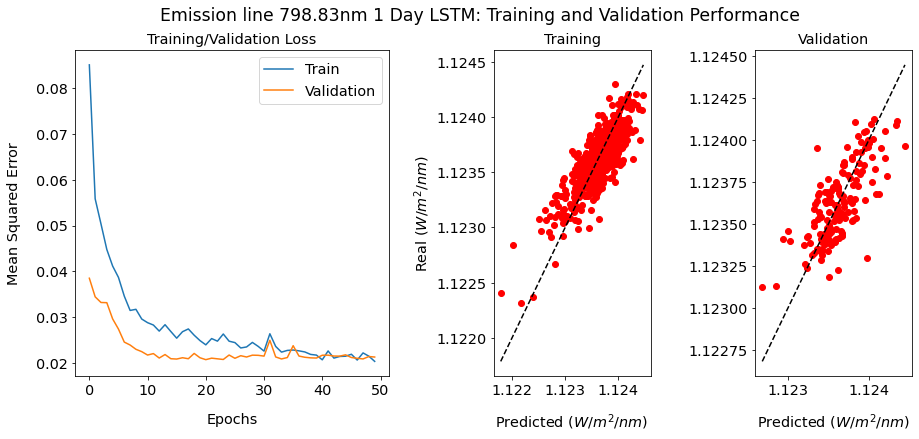

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1, 1]})

plt.subplots_adjust(wspace=0.5)#, hspace=None)
plt.suptitle("Emission line "+line+"nm "+timeTerm+" "+net.upper()+": Training and Validation Performance", fontsize='xx-large')

ax1.plot(f.history['loss'], label='Train')
ax1.plot(f.history['val_loss'], label='Validation')
ax1.set_title('Training/Validation Loss', fontsize='x-large')
ax1.set_xlabel('Epochs', labelpad=15, fontsize='x-large')
ax1.set_ylabel('Mean Squared Error', labelpad=15, fontsize='x-large')
ax1.legend(fontsize='x-large')
ax1.tick_params(axis='x', labelsize='x-large' ) 
ax1.tick_params(axis='y', labelsize='x-large' ) 

ax2.scatter(yTrain,yTrainP, color='red')
ax2.set_xlabel('Predicted ($W/m^2/nm$)', labelpad=15, fontsize='x-large')
ax2.set_ylabel('Real ($W/m^2/nm$)', fontsize='x-large')
ax2.set_title('Training', fontsize='x-large')
#plt.plot([-2,2],[-2,2])
ax2.plot([yTrain.min(), yTrain.max()], [yTrain.min(), yTrain.max()], color='black', 
         linestyle='--', label='optimal')
ax2.tick_params(axis='x', labelsize='x-large' ) 
ax2.tick_params(axis='y', labelsize='x-large' ) 

ax3.scatter(yVal,yValP, color='red')
ax3.set_xlabel('Predicted ($W/m^2/nm$)', labelpad=15, fontsize='x-large')
# ax3.set_ylabel('Real ($W/m^2/nm$)', fontsize='xx-large')
# ax3.set_yticks([])
ax3.set_title('Validation', fontsize='x-large')
#plt.plot([-2,2],[-2,2])
ax3.plot([yVal.min(), yVal.max()], [yVal.min(), yVal.max()], color='black', 
         linestyle='--', label='optimal')
ax3.tick_params(axis='x', labelsize='x-large') 
ax3.tick_params(axis='y', labelsize='x-large' ) 

#fig.savefig('./Figures/LSTM Training x Validation 6Hours.png', dpi=600, format='png')
fig.savefig('./Figures/SSI Predictions/'+line+'_'+net.upper()+'_Training x Validation_'+timeTerm+'.pdf', dpi=200, format='pdf')

### Predicting Test Set 3

In [103]:
TimeT = Time3
testSet = 'Set3'

rnnR2 = r2_score(yTest, yTestP)
rnnR, a = stats.pearsonr(np.squeeze(yTest), np.squeeze(yTestP))
rnnMSE = mean_squared_error(yTest, yTestP)
rnnMAPE = mean_absolute_percentage_error(yTest, yTestP)

r = "{:.1%}".format(rnnR)
r2 = "{:.1%}".format(rnnR2)
mse = "{:.2}".format(rnnMSE)
mape = "{:.4%}".format(rnnMAPE)

textstr = '\n'.join(('R = '+r,
                    r'$R^2$ = '+r2,
                     'MSE = '+mse,
                     'MAPE = '+mape))

In [104]:
data = []
for i in TimeT:
    data.append(str(date.fromordinal(int(i))))

datesT = dates.date2num(data)

hfmt = dates.DateFormatter('%m/%d')

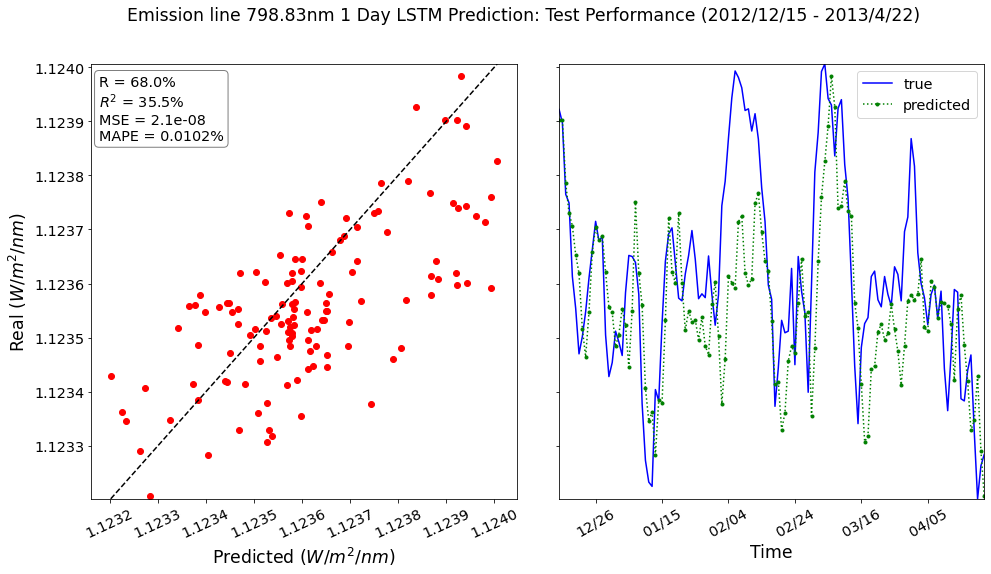

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)

plt.subplots_adjust(wspace=0.1)#, hspace=None)

mi = np.min([yTestP.min(),yTest.min()])
ma = np.max([yTestP.max(),yTest.max()])

yAxis = [mi,ma]

plt.suptitle("Emission line "+line+"nm "+timeTerm+" "+net.upper()+" Prediction: Test Performance (2012/12/15 - 2013/4/22)", fontsize='xx-large')

ax1.scatter(yTest, yTestP, color='red')
ax1.set_xlabel('Predicted ($W/m^2/nm$)', labelpad=5, fontsize='xx-large')
ax1.set_ylabel('Real ($W/m^2/nm$)', labelpad=5, fontsize='xx-large')
# ax1.set_title('Test')
ax1.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')
ax1.tick_params(axis='x', rotation=25, labelsize='x-large')
ax1.tick_params(axis='y', labelsize='x-large')

props = dict(boxstyle='round', facecolor='None', alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.0175, 0.975, textstr, transform=ax1.transAxes, fontsize='x-large',
        verticalalignment='top', bbox=props)


ax2.plot(datesT,yTest,'b-',label='true')
ax2.plot(datesT,yTestP,'g.:',label='predicted')
ax2.set_ylim(yAxis)
ax2.set_xlim([datesT[0],datesT[-1]])
ax2.set_xlabel('Time', labelpad=5, fontsize='xx-large')
ax2.tick_params(axis='x', rotation=30, labelsize='x-large')
ax2.legend(fontsize='x-large')

fig.savefig('./Figures/SSI Predictions/'+line+'_'+net.upper()+'_Test'+testSet+'_'+timeTerm+'.pdf', dpi=200, format='pdf', pad_inches=0.1)

Ploting and comparing the 50 first true and predicted values:

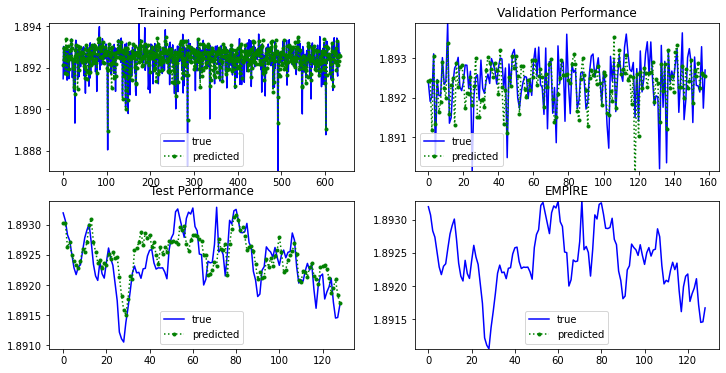

In [82]:
S3_3 = np.asarray(np.loadtxt('./partial_output_files/Satire_121.5_129dias.csv'))
E3_3 = np.asarray(np.loadtxt('./partial_output_files/Empire_121.5_129dias.csv'))

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 6))
#plt.figure()
ax1.plot(yTrain,'b-',label='true')
ax1.plot(yTrainP,'g.:',label='predicted')
ax1.set_ylim((yTrain.min(),yTrain.max()))
ax1.set_title('Training Performance')
ax1.legend()

#plt.figure()
ax2.plot(yVal,'b-',label='true')
ax2.plot(yValP,'g.:',label='predicted')
ax2.set_ylim((yVal.min(),yVal.max()))
ax2.set_title('Validation Performance')
ax2.legend()

ax3.plot(yTest,'b-',label='true')
ax3.plot(yTestP,'g.:',label='predicted')
#ax3.set_ylim((yTrain.min(),yTrain.max()))
ax3.set_title('Test Performance')
ax3.legend()

ax4.plot(yTest,'b-',label='true')
ax4.plot(E3_3,'g.:',label='predicted')
ax4.set_ylim((yTest.min(),yTest.max()))
ax4.set_title('EMPIRE')
ax4.legend()

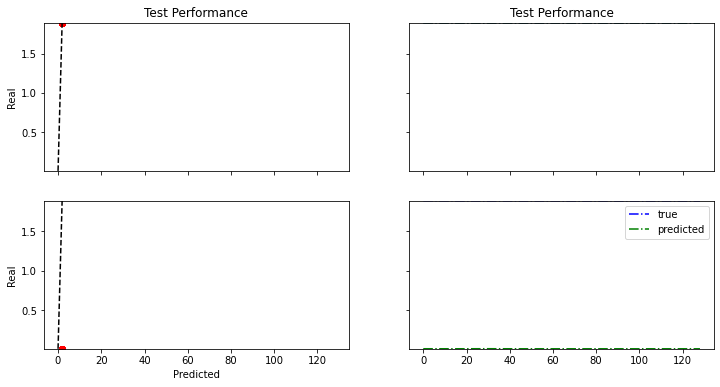

In [83]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

mi = np.min([yTestP.min(),yTest.min(),E3_3.min()])
ma = np.max([yTestP.max(),yTest.max(),E3_3.max()])

yAxis = [mi,ma]

ax1.scatter(yTest, yTestP, color='red')
# ax1.set_xlabel('Predicted')
ax1.set_ylabel('Real')
ax1.set_title('Test Performance')
ax1.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')

ax2.plot(yTest,'b-.',label='true')
ax2.plot(yTestP,'g-.',label='predicted')
ax2.set_ylim(yAxis)
ax2.set_title('Test Performance')

ax3.scatter(yTest, E3_3, color='red')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Real')
# ax3.set_title('Test')
ax3.plot(yAxis,yAxis, color='black', 
         linestyle='--', label='optimal')

ax4.plot(yTest,'b-.',label='true')
ax4.plot(E3_3,'g-.',label='predicted')
ax4.set_ylim(yAxis)
# ax4.set_title('E Performance')
ax4.legend()
ax4.legend()

In [84]:
from matplotlib import dates

data3 = []
for i in Time3:
    data3.append(str(date.fromordinal(int(i))))

dates3 = dates.date2num(data3)

hfmt = dates.DateFormatter('%m/%d')

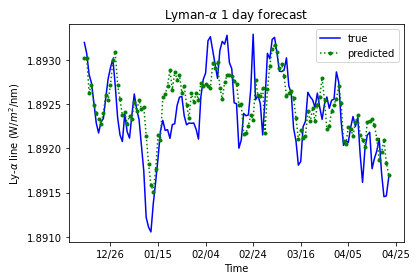

In [85]:
ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)

plt.plot(dates3,yTest,'b-',label='true')
plt.plot(dates3,yTestP,'g.:',label='predicted')
#ax3.set_ylim((yTrain.min(),yTrain.max()))
plt.title(r'Lyman-$\alpha$ 1 day forecast')
plt.xlabel('Time')
plt.ylabel(r'Ly-$\alpha$ line (W/$m^2$/nm)')
plt.legend()

In [86]:
import julian
lAModel = np.asarray(np.loadtxt('./partial_output_files/lyman_alpha_model_ssi.csv',delimiter=','))

stdTime = julian.from_jd(lAModel[-1,0], fmt='jd')
print(stdTime)
print(dates3.shape)
print(lAModel.shape)


OSError: ./partial_output_files/lyman_alpha_model_ssi.csv not found.

In [87]:
print(date.fromordinal(int(Time3[0])))
print(date.fromordinal(int(Time3[-1])))

2012-12-15
2013-04-22


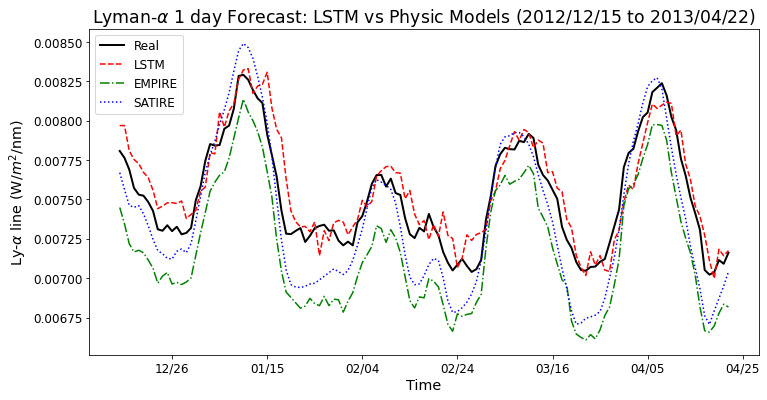

In [26]:
fig = plt.figure(figsize=(12, 6))

ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)

plt.title(r'Lyman-$\alpha$ 1 day Forecast: LSTM vs Physic Models (2012/12/15 to 2013/04/22)',fontsize='xx-large')
plt.plot(dates3,yTest, linewidth = 2, color='black', linestyle='-', label = 'Real')
plt.plot(dates3,yTestP, color='red', linestyle='--', label = 'LSTM')
plt.plot(dates3,E3_3, color='green', linestyle='-.', label = 'EMPIRE')
plt.plot(dates3,S3_3, color='blue', linestyle=':', label = 'SATIRE')
#plt.plot(dates3,lAModel[:,2])
plt.tick_params(labelsize='large')
plt.xlabel('Time',fontsize='x-large')
plt.ylabel(r'Ly-$\alpha$ line (W/$m^2$/nm)',fontsize='x-large')
plt.legend(fontsize='large')
fig.savefig('./Figures/SSI Predictions/'+net.upper()+'_Test'+testSet+'_PhysicalModels.png', dpi=200, format='png', pad_inches=0.1)

In [27]:
from matplotlib import dates

data3 = []
for i in Time3:
    data3.append(str(date.fromordinal(int(i))))

dates3 = dates.date2num(data3)

hfmt = dates.DateFormatter('%m/%d')

In [28]:
str(date.fromordinal(int(Time3[0])))

'2012-12-15'

(0.0066073853, 0.0084908617)

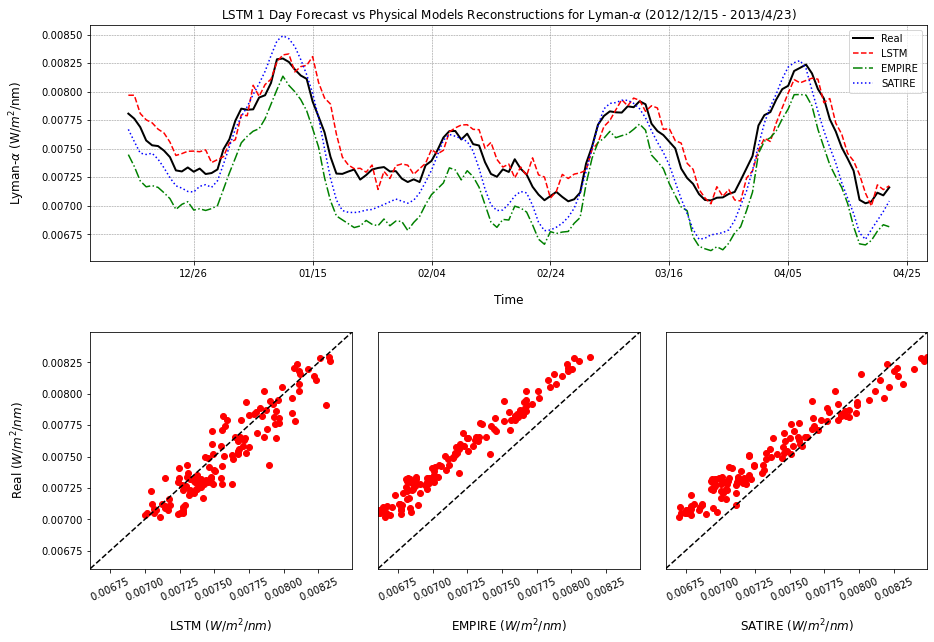

In [29]:
f = plt.figure(figsize=(15, 10))

minYAxis = np.min([np.min(yTest),np.min(yTestP),np.min(E3_3),np.min(S3_3)])
maxYAxis = np.max([np.max(yTest),np.max(yTestP),np.max(E3_3),np.max(S3_3)])

plt.subplots_adjust(wspace=0.1,hspace=0.3)

ax1 = plt.subplot(211)

ax = plt.gca()
ax.xaxis.set_major_formatter(hfmt)


ax1.set_title(r'LSTM 1 Day Forecast vs Physical Models Reconstructions for Lyman-$\alpha$ (2012/12/15 - 2013/4/23)', fontsize='xx-large')
ax1.plot(dates3,yTest, linewidth = 2, color='black', linestyle='-', label = 'Real')
ax1.plot(dates3,yTestP, color='red', linestyle='--', label = 'LSTM')
ax1.plot(dates3,E3_3, color='green', linestyle='-.', label = 'EMPIRE')
ax1.plot(dates3,S3_3, color='blue', linestyle=':', label = 'SATIRE')
#plt.plot(dates3,lAModel[:,2])
ax1.set_xlabel('Time', fontsize='large', labelpad=15) #, fontweight='bold')
ax1.set_ylabel(r'Lyman-$\alpha$ (W/$m^2$/nm)', fontsize='large', labelpad=15)
ax1.legend()
ax1.grid(color = '#888888', linestyle = '--', linewidth = 0.5)

ax2 = plt.subplot(234)
ax2.tick_params(axis='x', rotation=25)
ax2.scatter(yTestP,yTest, color='red')
ax2.set_xlabel('LSTM ($W/m^2/nm$)', labelpad=15, fontsize='large') #, fontweight='bold')
ax2.set_ylabel('Real ($W/m^2/nm$)', labelpad=15, fontsize='large') #, fontsize='large', fontweight='bold')
# ax2.set_title('Training')
#plt.plot([-2,2],[-2,2])
ax2.plot([minYAxis, maxYAxis], [minYAxis, maxYAxis], color='black', 
         linestyle='--', label='optimal')
# ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_xlim(minYAxis, maxYAxis)
ax2.set_ylim(minYAxis, maxYAxis)

ax3 = plt.subplot(235)
ax3.tick_params(axis='x', rotation=25)
ax3.scatter(E3_3,yTest, color='red')
ax3.set_xlabel('EMPIRE ($W/m^2/nm$)', labelpad=15, fontsize='large') #, fontweight='bold'
ax3.set_yticks([])
# ax3.set_ylabel('Real ($W/m^2$)')
# ax3.set_title('Validation')
#plt.plot([-2,2],[-2,2])
ax3.plot([minYAxis, maxYAxis], [minYAxis, maxYAxis], color='black', 
         linestyle='--', label='optimal')
# ax3.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax3.set_xlim(minYAxis, maxYAxis)
ax3.set_ylim(minYAxis, maxYAxis)

ax4 = plt.subplot(236)
ax4.tick_params(axis='x', rotation=25)
ax4.scatter(S3_3,yTest, color='red')
ax4.set_xlabel('SATIRE ($W/m^2/nm$)', labelpad=15, fontsize='large') #, fontweight='bold')
ax4.set_yticks([])
# ax4.set_ylabel('Real ($W/m^2$)')
# ax4.set_title('Validation')
#plt.plot([-2,2],[-2,2])
ax4.plot([minYAxis, maxYAxis], [minYAxis, maxYAxis], color='black', 
         linestyle='--', label='optimal')
ax4.set_xlim(minYAxis, maxYAxis)
ax4.set_ylim(minYAxis, maxYAxis)

# ax4.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

7
[4, 16, 32, 64, 128, 256, 512]


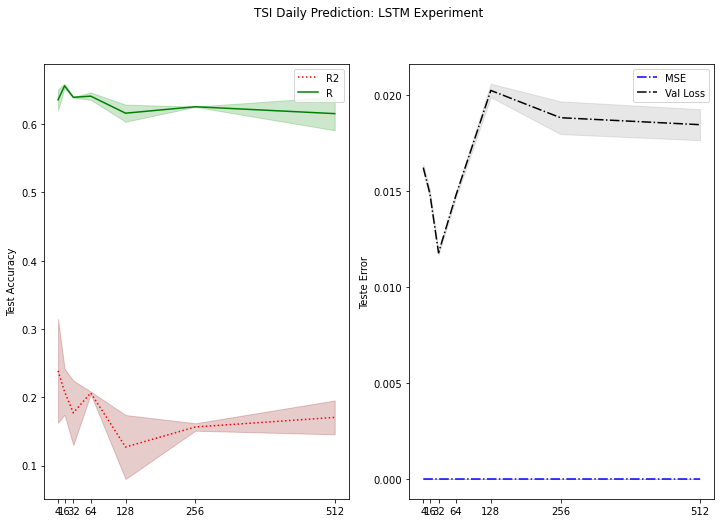

In [24]:
# df1 = np.asarray(lstm)
# error = np.asarray(error)

# n_tests = testsqtd #number of tests for each setting
# n_groups = int(df1.shape[0]/n_tests) #number of groups
# intervals = range(0, n_groups*n_tests, n_tests) #index intervals for each group of values
# #groups = np.unique(df1[:, 0]).astype(np.int32) # Each group label
# groups = batchSizes
# colors = ['red', 'green', 'blue', 'black'] # boxplot's colors by type RNN
# print(n_groups)
# print(groups)

# R2MeansStds = [] # R2
# RMeansStds = [] # R
# MSEMeansStds = [] # MSE
# ValLossMeansStds = [] # Validation Loss

# for i in range(n_groups):
#     R2MeansStds.append([np.mean(df1[intervals[i]:intervals[i]+n_tests, 1]), np.std(df1[intervals[i]:intervals[i]+n_tests, 1])])
#     RMeansStds.append([np.mean(df1[intervals[i]:intervals[i]+n_tests, 2]), np.std(df1[intervals[i]:intervals[i]+n_tests, 2])])
#     MSEMeansStds.append([np.mean(df1[intervals[i]:intervals[i]+n_tests, 3]), np.std(df1[intervals[i]:intervals[i]+n_tests, 3])])
#     ValLossMeansStds.append([np.mean(error[intervals[i]:intervals[i]+n_tests, 1]), np.std(error[intervals[i]:intervals[i]+n_tests, 1])])

# R2MeansStds = np.asarray(R2MeansStds)
# RMeansStds = np.asarray(RMeansStds)
# MSEMeansStds = np.asarray(MSEMeansStds)
# ValLossMeansStds = np.asarray(ValLossMeansStds)

# fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# plt.suptitle('TSI Daily Prediction: LSTM Experiment')

# ax1.plot(groups, R2MeansStds[:,0], c=colors[0], label='R2', linestyle=':')
# ax1.fill_between(groups, R2MeansStds[:,0] - R2MeansStds[:,1], R2MeansStds[:,0] + R2MeansStds[:,1], color='#880000', alpha=0.2)

# ax1.plot(groups, RMeansStds[:,0], c=colors[1], label='R', linestyle='-')
# ax1.fill_between(groups, RMeansStds[:,0] - RMeansStds[:,1], RMeansStds[:,0] + RMeansStds[:,1], color='#008800', alpha=0.2)

# ax2.plot(groups, MSEMeansStds[:,0], c=colors[2], label='MSE', linestyle='-.')
# ax2.fill_between(groups, MSEMeansStds[:,0] - MSEMeansStds[:,1], MSEMeansStds[:,0] + MSEMeansStds[:,1], color='#000088', alpha=0.2)

# ax2.plot(groups, ValLossMeansStds[:,0], c=colors[3], label='Val Loss', linestyle='-.')
# ax2.fill_between(groups, ValLossMeansStds[:,0] - ValLossMeansStds[:,1], ValLossMeansStds[:,0] + ValLossMeansStds[:,1], color='#888888', alpha=0.2)

# ax1.legend()
# ax2.legend()

# ax1.set_xticks(groups) # repositioning labels batchsize
# ax2.set_xticks(groups)
# ax1.set_ylabel('Test Accuracy')
# ax2.set_ylabel('Teste Error')
# plt.show()